# КМ-3. Определение эффективной теплопроводности

## 1. Двумерная версия программы

In [31]:
"""
Программа решения двумерного уравнения диффузии.
"""
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def Solve2D(Lx,Nx,Ly,Ny,GammaFun,CSourceFun,VSourceFun,CoefW,ValW,CoefE,ValE,CoefS,ValS,CoefN,ValN):
    
    #Ширина КО
    dx = Lx/Nx
    dy = Ly/Ny
    #грани КО
    XFace = np.linspace(0.0,Lx,Nx+1)
    YFace = np.linspace(0.0,Ly,Ny+1)
    #Площади граней
    dX = np.zeros(Nx)
    dX[:] = XFace[1:Nx+1] - XFace[0:Nx]
    dY = np.zeros(Ny)
    dY[:] = YFace[1:Ny+1] - YFace[0:Ny]
    
    #Создаем массив XP и YP с центрами КО
    XP = np.zeros(Nx)  
    XP = (XFace[0:Nx] + XFace[1:Nx+1])/2.0
    YP = np.zeros(Ny)  
    YP = (YFace[0:Ny] + YFace[1:Ny+1])/2.0
    
    #объемы КО
    VolumeP = np.zeros(shape = (Nx,Ny), dtype = float)
    for ix in range(Nx):
        for iy in range(Ny):
            VolumeP[ix,iy] = dX[ix]*dY[iy]

    #Массив с обобщенным коэффициентом диффузии в центрах КО
    Gamma = np.zeros(shape = (Nx,Ny), dtype = float)
    for ix in range(Nx):
        for iy in range(Ny):
            Gamma[ix,iy] = GammaFun(XP[ix],YP[iy])
    
    CSource = np.zeros(shape = (Nx,Ny),dtype=float)
    VSource = np.zeros(shape = (Nx,Ny),dtype=float)
    
    for ix in range(Nx):
        for iy in range(Ny):
            CSource[ix,iy] = CSourceFun(XP[ix],YP[iy])
            VSource[ix,iy] = VSourceFun(XP[ix],YP[iy])
    
    A = np.zeros((Nx*Ny, Nx*Ny), dtype=float)
    b = np.zeros(Nx*Ny, dtype = float)
    
    #перевод индексов в номер КО
    def k(i,j):
        return i + j*Nx
    #заполнение матрицы
    for ix in range(0,Nx):
        for iy in range(0,Ny):
            kp = k(ix,iy)
            b[kp] = b[kp] + CSource[ix,iy]*VSource[ix,iy]*VolumeP[ix,iy]
            A[kp,kp] = A[kp,kp] + CSource[ix,iy]*VolumeP[ix,iy]
            
            if ix == Nx-1:
                #учитываем влияние правой границы
                anb = 2.0*Gamma[ix,iy]*CoefE(YP[iy])/(CoefE(YP[iy])*dX[ix] + 2.0*Gamma[ix,iy])*dY[iy]
                A[kp,kp] = A[kp,kp] + anb
                b[kp] = b[kp] + anb*ValE(YP[iy])
                
            else:
                #учитываем влияние правого КО
                ke = k(ix + 1, iy)
                anb = 2.0*Gamma[ix,iy]*Gamma[ix+1,iy]/(Gamma[ix,iy]*dX[ix+1] + Gamma[ix+1,iy]*dX[ix])*dY[iy]
                A[kp,kp] = A[kp,kp] + anb
                A[kp,ke] = -anb
                A[ke,ke] = A[ke,ke] + anb
                A[ke,kp] = -anb 
            if ix == 0:
                #учитываем влияние левой границы
                anb = 2.0*Gamma[ix,iy]*CoefW(YP[iy])/(CoefW(YP[iy])*dX[ix] + 2.0*Gamma[ix,iy])*dY[iy]
                A[kp,kp] = A[kp,kp] + anb
                b[kp] = b[kp] + anb*ValW(YP[iy])
                
            if iy == Ny-1:
                #учитываем влияние верхней границы
                anb = 2.0*Gamma[ix,iy]*CoefN(XP[ix])/(CoefN(XP[ix])*dY[iy] + 2.0*Gamma[ix,iy])*dX[ix]
                A[kp,kp] = A[kp,kp] + anb
                b[kp] = b[kp] + anb*ValN(XP[ix])
            else:
                #учитываем влияние верхнего КО
                kn = k(ix, iy+1)
                anb = 2.0*Gamma[ix,iy]*Gamma[ix,iy+1]/(Gamma[ix,iy]*dY[iy+1] + Gamma[ix,iy+1]*dY[iy])*dX[ix]
                A[kp,kp] = A[kp,kp] + anb
                A[kp,kn] = -anb
                A[kn,kn] = A[kn,kn] + anb
                A[kn,kp] = -anb 
            if iy == 0:
                #учитываем влияние нижней границы
                anb = 2.0*Gamma[ix,iy]*CoefS(XP[ix])/(CoefS(XP[ix])*dY[iy] + 2.0*Gamma[ix,iy])*dX[ix]
                A[kp,kp] = A[kp,kp] + anb
                b[kp] = b[kp] + anb*ValS(XP[ix])          
            
                
    Phi = np.linalg.solve(A, b)
    Phi2D = np.zeros(shape = (Nx,Ny), dtype = float)
    for ix in range(0,Nx):
        for iy in range(0,Ny):
            kp = k(ix,iy)
            Phi2D[ix,iy] = Phi[kp]
   
    return XP, XFace, YP, YFace, Phi2D
    
  

## ПРИМЕР 1

In [32]:
#Параметры тестовой задачи
Lx = 3.0 #длина расчетной области
Nx = 50 #количество контрольных объемов
Ly = 4.0 #высота расчетной области
Ny = 50 #количество контрольных объемов

#ГРАНИЧНЫЕ УСЛОВИЯ
#Функции для ГУ сверху
def CoefUp(x):
    return 0.0
def ValUp(x):
    return 0.0

#Функции для ГУ снизу
def CoefDown(x):
    return 0.0
def ValDown(x):
    return 0.0

#Функции для ГУ слева
def CoefLeft(y):
    return 1.0e20
def ValLeft(y):
    return 0.0

#Функции для ГУ справа
def CoefRight(y):
    if y > 2.0:
        return 1.0e-20
    else:
        return 100.0    
def ValRight(y):
    if y > 2.0:
        return 100.0/1.0e-20
    else:
        return 1.0
#СВОЙСТВА
#Задание коэффициента обобщенного переноса  
def LambdaFun(x,y):
    return 1.0

#ИСТОЧНИК
#Задание источника
def CSourceFun(x,y):
    return 1.0e-20
def VSourceFun(x,y):
    Qv = 0.0e1
    return Qv/1.0e-20

#решение
x, xf, y, yf, T = Solve2D(Lx,Nx,Ly,Ny,LambdaFun,CSourceFun,VSourceFun,CoefLeft,ValLeft,CoefRight,ValRight,CoefDown,ValDown,CoefUp,ValUp)

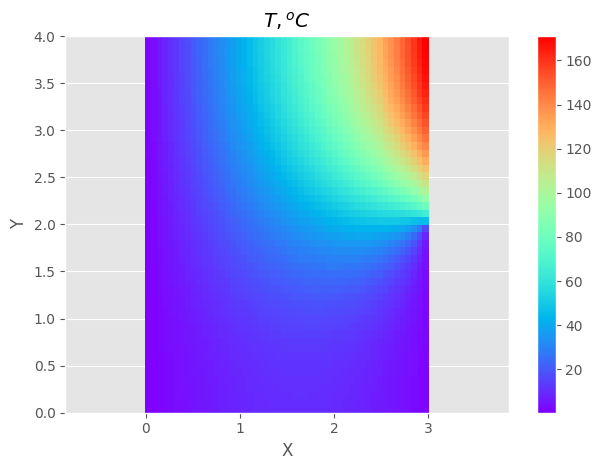

In [33]:
#Строим графики
fig = plt.figure('fig1')
plt.pcolor(xf, yf, T.T,cmap='rainbow')
plt.xlabel('X')
plt.ylabel('Y')
plt.title("$T,^oC$")
plt.colorbar()
plt.xlim(0.0,Lx)
plt.ylim(0.0,Ly)
plt.axis('equal')
plt.tight_layout()
plt.show()

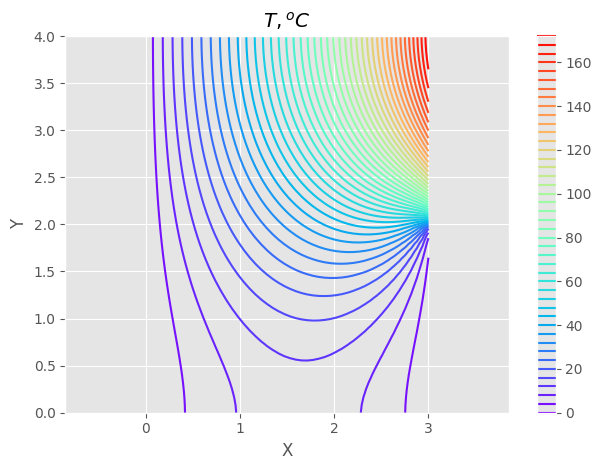

In [34]:
#Строим графики
fig = plt.figure('fig1')
plt.contour(T.T,Nx,cmap='rainbow',extent = (0.0,Lx,0.0,Ly),linewidths = 1.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title("$T,^oC$")
plt.colorbar()
plt.xlim(0.0,Lx)
plt.ylim(0.0,Ly)
plt.axis('equal')
plt.tight_layout()
plt.show()

## ПРИМЕР 2

In [35]:
#Параметры тестовой задачи
Lx = 3.0 #длина расчетной области
Nx = 50 #количество контрольных объемов
Ly = 3.0 #высота расчетной области
Ny = 50 #количество контрольных объемов

#ГРАНИЧНЫЕ УСЛОВИЯ
#Функции для ГУ сверху
def CoefUp(x):
    return 1.0e20
def ValUp(x):
    return 100.0

#Функции для ГУ снизу
def CoefDown(x):
    return 1.0e20
def ValDown(x):
    return 100.0

#Функции для ГУ слева
def CoefLeft(y):
    return 1.0e20
def ValLeft(y):
    return 100.0

#Функции для ГУ справа
def CoefRight(y):
    return 1.0e20
def ValRight(y):
    return 100.0
#СВОЙСТВА
#Задание коэффициента обобщенного переноса  
def LambdaFun(x,y):
    return 1.0

#ИСТОЧНИК
#Задание источника
def CSourceFun(x,y):
    return 1.0e-20
def VSourceFun(x,y):
    if (x-Lx/2.0)**2.0 + (y-Ly/2.0)**2.0 <= 1.0:
        Qv = 1.0e2
    else:
        Qv = 0.0
    return Qv/1.0e-20

#решение
x, xf, y, yf, T = Solve2D(Lx,Nx,Ly,Ny,LambdaFun,CSourceFun,VSourceFun,CoefLeft,ValLeft,CoefRight,ValRight,CoefDown,ValDown,CoefUp,ValUp)

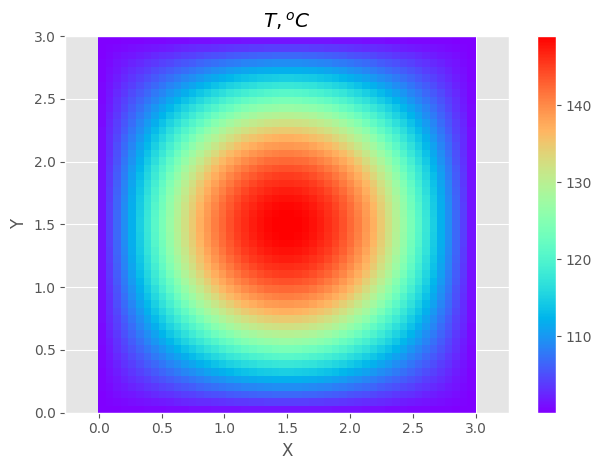

In [36]:
#Строим графики
fig = plt.figure('fig1')
plt.pcolor(xf, yf, T.T,cmap='rainbow')
plt.xlabel('X')
plt.ylabel('Y')
plt.title("$T,^oC$")
plt.colorbar()
plt.xlim(0.0,Lx)
plt.ylim(0.0,Ly)
plt.axis('equal') #Устанавливает равенство масштабов по осям x и y
plt.tight_layout()
plt.show()

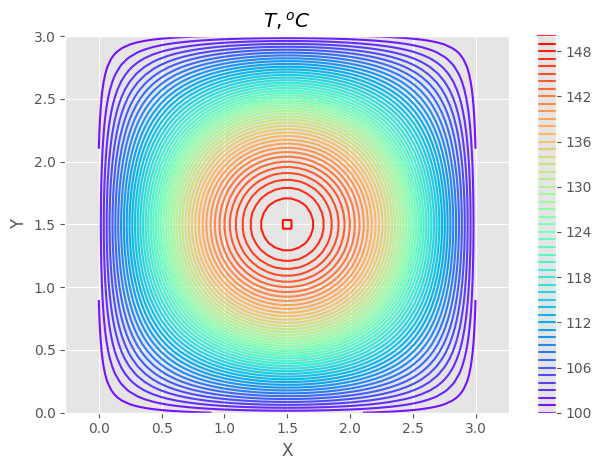

In [37]:
#Строим графики
fig = plt.figure('fig1')
plt.contour(T.T,Nx,cmap='rainbow',extent = (0.0,Lx,0.0,Ly),linewidths = 1.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title("$T,^oC$")
plt.colorbar()
plt.xlim(0.0,Lx)
plt.ylim(0.0,Ly)
plt.axis('equal') #Устанавливает равенство масштабов по осям x и y
plt.tight_layout()
plt.show()

In [38]:
"""
Программа решения двумерного уравнения диффузии.
"""
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import linalg

plt.style.use('ggplot')

def Solve2D(Lx,Nx,Ly,Ny,GammaFun,CSourceFun,VSourceFun,CoefW,ValW,CoefE,ValE,CoefS,ValS,CoefN,ValN):
    
    #Ширина КО
    dx = Lx/Nx
    dy = Ly/Ny
    #грани КО
    XFace = np.linspace(0.0,Lx,Nx+1)
    YFace = np.linspace(0.0,Ly,Ny+1)
    #Площади граней
    dX = np.zeros(Nx)
    dX[:] = XFace[1:Nx+1] - XFace[0:Nx]
    dY = np.zeros(Ny)
    dY[:] = YFace[1:Ny+1] - YFace[0:Ny]
    
    #Создаем массив XP и YP с центрами КО
    XP = np.zeros(Nx)  
    XP = (XFace[0:Nx] + XFace[1:Nx+1])/2.0
    YP = np.zeros(Ny)  
    YP = (YFace[0:Ny] + YFace[1:Ny+1])/2.0
    
    #объемы КО
    VolumeP = np.zeros(shape = (Nx,Ny), dtype = float)
    for ix in range(Nx):
        for iy in range(Ny):
            VolumeP[ix,iy] = dX[ix]*dY[iy]

    #Массив с обобщенным коэффициентом диффузии в центрах КО
    Gamma = np.zeros(shape = (Nx,Ny), dtype = float)
    for ix in range(Nx):
        for iy in range(Ny):
            Gamma[ix,iy] = GammaFun(XP[ix],YP[iy])
    
    CSource = np.zeros(shape = (Nx,Ny),dtype=float)
    VSource = np.zeros(shape = (Nx,Ny),dtype=float)
    
    for ix in range(Nx):
        for iy in range(Ny):
            CSource[ix,iy] = CSourceFun(XP[ix],YP[iy])
            VSource[ix,iy] = VSourceFun(XP[ix],YP[iy])
    
    A = np.zeros((Nx*Ny, Nx*Ny), dtype=float)
    b = np.zeros(Nx*Ny, dtype = float)
    
    #перевод индексов в номер КО
    def k(i,j):
        return i + j*Nx
    #заполнение матрицы
    for ix in range(0,Nx):
        for iy in range(0,Ny):
            kp = k(ix,iy)
            b[kp] = b[kp] + CSource[ix,iy]*VSource[ix,iy]*VolumeP[ix,iy]
            A[kp,kp] = A[kp,kp] + CSource[ix,iy]*VolumeP[ix,iy]
            
            if ix == Nx-1:
                #учитываем влияние правой границы
                anb = 2.0*Gamma[ix,iy]*CoefE/(CoefE*dX[ix] + 2.0*Gamma[ix,iy])*dY[iy]
                A[kp,kp] = A[kp,kp] + anb
                b[kp] = b[kp] + anb*ValE
                
            else:
                #учитываем влияние правого КО
                ke = k(ix + 1, iy)
                anb = 2.0*Gamma[ix,iy]*Gamma[ix+1,iy]/(Gamma[ix,iy]*dX[ix+1] + Gamma[ix+1,iy]*dX[ix])*dY[iy]
                A[kp,kp] = A[kp,kp] + anb
                A[kp,ke] = -anb
                A[ke,ke] = A[ke,ke] + anb
                A[ke,kp] = -anb 
            if ix == 0:
                #учитываем влияние левой границы
                anb = 2.0*Gamma[ix,iy]*CoefW/(CoefW*dX[ix] + 2.0*Gamma[ix,iy])*dY[iy]
                A[kp,kp] = A[kp,kp] + anb
                b[kp] = b[kp] + anb*ValW

             #Задаем периодические ГУ
            if iy == Ny-1:
                kn = k(ix, 0)
                anb = 2.0*Gamma[ix,iy]*Gamma[ix,0]/(Gamma[ix,iy]*dY[0] + Gamma[ix,0]*dY[iy])*dX[ix]
                A[kp,kp] = A[kp,kp] + anb
                A[kp,kn] = -anb
                A[kn,kn] = A[kn,kn] + anb
                A[kn,kp] = -anb           
                
         
            else:
                #учитываем влияние верхнего КО
                kn = k(ix, iy+1)
                anb = 2.0*Gamma[ix,iy]*Gamma[ix,iy+1]/(Gamma[ix,iy]*dY[iy+1] + Gamma[ix,iy+1]*dY[iy])*dX[ix]
                A[kp,kp] = A[kp,kp] + anb
                A[kp,kn] = -anb
                A[kn,kn] = A[kn,kn] + anb
                A[kn,kp] = -anb 
            if iy == 0:
                #учитываем влияние нижней границы
                anb = 2.0*Gamma[ix,iy]*CoefS/(CoefS*dY[iy] + 2.0*Gamma[ix,iy])*dX[ix]
                A[kp,kp] = A[kp,kp] + anb
                b[kp] = b[kp] + anb*ValS          
            
                
    Phi,info = linalg.gmres(A, b)
    Phi2D = np.zeros(shape = (Nx,Ny), dtype = float)
    for ix in range(0,Nx):
        for iy in range(0,Ny):
            kp = k(ix,iy)
            Phi2D[ix,iy] = Phi[kp]
   
    qsr = 0
    for k in range(Ny):
        #qsr = qsr + (ValW-Phi2D[0,k])/(1/CoefW+dx/(2*Gamma[0,k])) #левая граница
        qsr += CoefW * (ValW - Phi2D[0,iy])

        #Ja = Ja + (TRight-Phi2D[Nx-1,j])/(1/CoefE+dx/(2*Gamma[0,j]))
    qsr = qsr/Ny
    
    Lambdaeff = abs(-qsr*Lx/((ValW-ValE)-(2*qsr/CoefW)))
    
    return XP, XFace, YP, YFace, Phi2D, Gamma, qsr, Lambdaeff
    
  

In [91]:
#Параметры тестовой задачи
w = 4
delta1 = 1.0
delta2 = 0.5

Lx = (w+1)*delta1+w*delta2 #длина расчетной области
Nx = 50 #количество контрольных объемов
Ly = 3*delta2 #высота расчетной области
Ny = 50 #количество контрольных объемов
Lambda = 1.0 #коэффициент теплопроводности
coef_lambda = 50 # lamda2 / labda1
qv = 0.0 #внутреннее тепловыделение

alphaLeft = 1.0
TLeft = 1.0
alphaRight = 1.0
TRight = 0.0
alphaUp = 0.0
TUp = 0.0
alphaDown = 0.0
TDown = 0.0

    
def LambdaFun(x,y):
    retVal = Lambda
    if x>=delta1 and x<=delta1+delta2 and y>=0 and y<=delta2/2:
        retVal= coef_lambda*Lambda
    if x>=2*delta1+delta2 and x<=2*delta1+2*delta2 and y>=delta2/2 and y<=delta2/2 + delta2:
        retVal=coef_lambda*Lambda
    if x>=3*delta1+2*delta2 and x<=3*delta1+3*delta2 and y>=delta2/2 + delta2 and y<=delta2/2 + 2*delta2:
        retVal=coef_lambda*Lambda
    if x>=4*delta1+3*delta2 and x<=4*delta1+4*delta2 and y>=0 and y<=delta2/2:
        retVal=coef_lambda*Lambda

    if x>=delta1 and x<=delta1+delta2 and y>=delta2/2 + 2*delta2 and y<=delta2/2 + 2*delta2 + delta2/2:
        retVal=coef_lambda*Lambda
    if x>=4*delta1 + 3*delta2 and x<=4*delta1+4*delta2 and y>=delta2/2 + 2*delta2 and y<=delta2/2 + 2*delta2 + delta2/2:
        retVal=coef_lambda*Lambda
        
    return retVal
   
def LambdaFun(x,y):
    retVal = Lambda
    values_x = [(idx*delta1 + (idx -1)*delta2, idx*delta1 + idx*delta2)for idx in range(w)]
    values_y = [(delta2/2 + 2*delta2, delta2/2 + 2*delta2 + delta2/2)for idx in range(w)]
    if x in values_x and y in values_y:
        retVal=coef_lambda*Lambda 
    return retVal

def CSourceFun(x,y):
    return 1.0e-20

def VSourceFun(x,y):
    return qv/1.0e-20

In [92]:
#Решение
x, xf, y, yf, T, Gamma, qsr, Lambdaeff = Solve2D(Lx,Nx,Ly,Ny,LambdaFun,CSourceFun,VSourceFun,alphaLeft,TLeft,alphaRight,TRight,alphaDown,TDown,alphaUp,TUp)
print("средняя плотность теплового потока", qsr)
print("эфеективный коэффициент теплопроводности", Lambdaeff)
print("число Био=",alphaRight*delta1/Lambda)
#Строим графики
fig = plt.figure('fig1',figsize=(150.0/25.4,150.0/25.4))
plt.pcolor(xf, yf, T.T,cmap='rainbow')
plt.xlabel('X')
plt.ylabel('Y')
plt.title("$T,^oC$")
plt.colorbar()
plt.xlim(0.0,Lx)
plt.ylim(0.0,Ly)
plt.show()

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

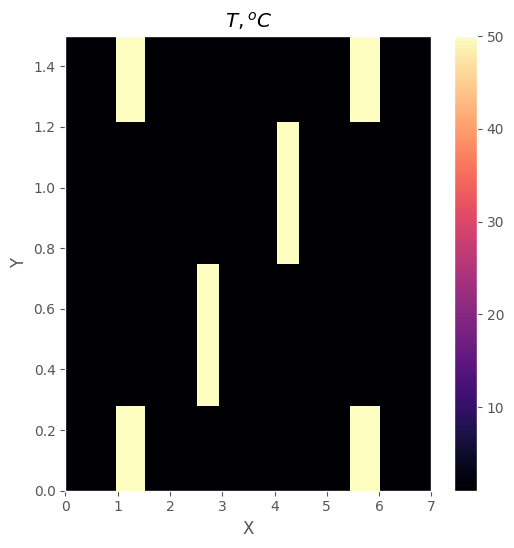

In [ ]:
#Строим графики
fig = plt.figure('fig1',figsize=(150.0/25.4,150.0/25.4))
plt.pcolor(xf, yf, Gamma.T,cmap='magma')
plt.xlabel('X')
plt.ylabel('Y')
plt.title("$T,^oC$")
plt.colorbar()
plt.xlim(0.0,Lx)
plt.ylim(0.0,Ly)
plt.show()

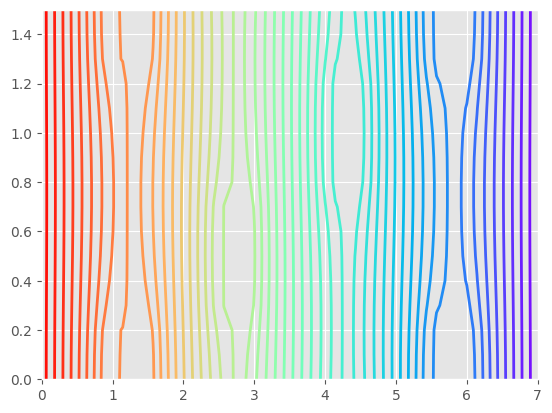

In [ ]:
plt.contour(T.T,Nx,cmap='rainbow',extent = (0.0,Lx,0.0,Ly),linewidths = 2)